## What skills you need to get for transition from Data Analyst to Data Scientist Role?

This section explores skills needed for transition using 2024 global job postings:
- Average number of skills needed for Data Jobs
- Gap analysis for Data Analyst and Data Scientists Roles

### Import Libraries

In [ ]:
from pathlib import Path
import ast

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import seaborn as sns

### Load Cleaned Dataset

In [2]:
df = pd.read_csv(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final.csv')

### The most in-demand Data Roles worldwide and the number of skills required for each of them
To understand which data roles are easiest to break into, we first need to identify the roles most in demand globally. A higher number of job postings typically indicates a lower barrier to entry and more available opportunities. 

At the same time, average number of  skills required in job descriptions provides insight into role complexity and the potential ease of entry.

In [3]:
df_2024 = df[(df['job_posted_date'].str.startswith('2024')) & (df['job_skills'].notna())].copy()

In [21]:
roles = ["Data Scientist", "Data Analyst"]
df_filtered = df[
    (df["job_title_short"].isin(roles)) &
    (df["job_skills"].notna())
].copy()

df_filtered["num_skills"] = df_filtered["job_skills"].apply(lambda x: len(x.split(",")))

grouped = df_filtered.groupby(["job_title_short", "num_skills"]).size().reset_index(name="num_postings")
mean_skills = df_filtered.groupby("job_title_short")["num_skills"].mean().round(0).astype(int)

# Plot
fig = px.scatter(
    grouped,
    x='num_skills',
    y='num_postings',
    color='job_title_short',
    title='Number of Skills vs Number of Job Postings (2024)',
    labels={
        'num_skills": "Number of Skills',
        'num_postings": "Number of Job Postings',
        'job_title_short": "Job Title'
    },
    template='plotly_white',
    color_discrete_map={
        'Data Scientist': 'steelblue',
        'Data Analyst': 'lightskyblue'
    }
)

# Uniform marker size
fig.update_traces(marker=dict(size=10, opacity=0.8))

# Add vertical lines for averages
for role in roles:
    avg = mean_skills[role]
    fig.add_vline(
        x=avg,
        line=dict(color="gray", dash="dash"),
        layer="below"
    )

# Add combined annotation box near the dotted lines (right side)
avg_text = (
    f'Avg number of skills<br>'
    f"Data Analyst: {mean_skills['Data Analyst']}<br>"
    f"Data Scientist: {mean_skills['Data Scientist']}"
)
fig.add_annotation(
    x=max(mean_skills) + 0.7,
    y=grouped["num_postings"].max(),
    text=avg_text,
    showarrow=False,
    align="left",
    bgcolor="white",
    bordercolor="gray",
    borderwidth=1,
    font=dict(color="black", size=12)
)

# Clean up x-axis ticks
fig.update_layout(
    width=850,
    height=500,
    legend_title_text="Job Title",
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 5, 10],
        title="Number of Skills per Job Posting"
    ),
    yaxis=dict(
        title="Number of Job Postings"
    )
)

fig.show()

The most popular data roles, **Data Scientist**, **Data Analyst**, and **Data Engineer**, stand out with significantly more job postings compared to others. At the same time, the lower number of skills required for **Data Analysts** suggests it is a more accessible **entry point** into the data field, making it a practical **base role for further analysis**.

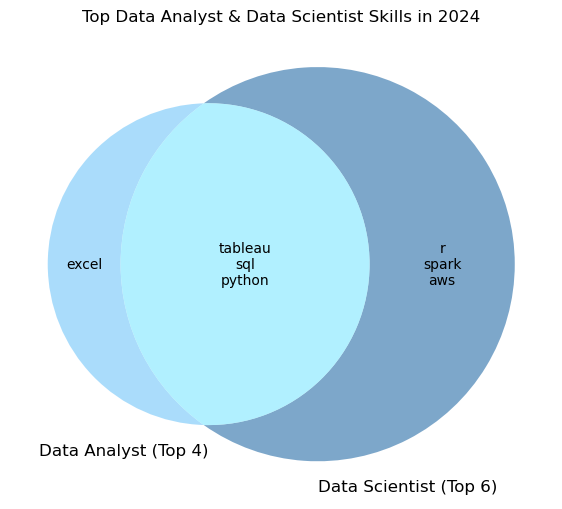

In [28]:
# Data Analyst: Top 4 skills in 2024
skills_da = df_2024[df_2024['job_title_short'] == 'Data Analyst']['job_skills']
skill_counts_da = {}
for s in skills_da:
    try:
        for skill in ast.literal_eval(s):
            skill_counts_da[skill] = skill_counts_da.get(skill, 0) + 1
    except Exception:
        continue
top4_da = sorted(skill_counts_da, key=skill_counts_da.get, reverse=True)[:4]

# Data Scientist: Top 6 skills in 2024
skills_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist']['job_skills']
skill_counts_ds = {}
for s in skills_ds:
    try:
        for skill in ast.literal_eval(s):
            skill_counts_ds[skill] = skill_counts_ds.get(skill, 0) + 1
    except Exception:
        continue
top6_ds = sorted(skill_counts_ds, key=skill_counts_ds.get, reverse=True)[:6]

# Convert to sets for Venn diagram
set_da = set(top4_da)
set_ds = set(top6_ds)

# Plot Venn diagram
plt.figure(figsize=(7,7))
venn = venn2(
    [set_da, set_ds],
    set_labels=('Data Analyst (Top 4)', 'Data Scientist (Top 6)'),
    set_colors=('lightskyblue', 'steelblue'),  # custom colors
    alpha=0.7  # transparency
)

# Annotate each section with skill names
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text('\n'.join(set_da - set_ds))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text('\n'.join(set_ds - set_da))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text('\n'.join(set_da & set_ds))

plt.title('Top Data Analyst & Data Scientist Skills in 2024')
plt.show()

To estimate how much each skill contributes to salary for Data Analyst roles vs Data Scientist roles — essentially controlling for overlaps between skills let's make these steps:

1. Prepare dataset
Filter by job role (DA or DS separately, or one-hot encode the role as a feature).
One-hot encode the job_skills column into binary columns (1 = skill present, 0 = skill absent).
Include other relevant features (e.g., location, job type, experience level) if you want to control for them.
Salary becomes your target y.

In [ ]:
# Ensure job_skills is a list and handle NaNs
df_2024['job_skills'] = df_2024['job_skills'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

# Filter Data Analyst roles
df_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist'].copy()

# Get top 10 skills (ignore empty lists)
top10_skills = (
    pd.Series([skill for skills in df_ds['job_skills'] if skills for skill in skills])
    .value_counts()
    .head(10)
    .index
)

# One-hot encode top 10 skills
for skill in top10_skills:
    df_ds[skill] = df_ds['job_skills'].apply(lambda skills: int(skill in skills))

# Features & target
X = df_ds[top10_skills]
y = df_ds['salary_month_avg_eur']

df_ds.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,python,sql,r,tableau,spark,aws,sas,azure,tensorflow,pytorch
1,Data Scientist,Data Scientist III (50% REMOTE) Jobs,"Huntsville, AL",via Clearance Jobs,Contractor,False,Georgia,2024-01-01 01:31:51,False,False,...,1,0,0,0,0,1,0,0,1,1
2,Data Scientist,Principal Data Scientist,"Palmyra, PA",via Ladders,Full-time,False,"New York, United States",2024-01-01 09:01:03,False,False,...,0,0,0,0,0,0,0,0,0,0
7,Data Scientist,Data Science,United States,via BeBee,Full-time,False,"Illinois, United States",2024-01-01 10:02:12,False,False,...,0,1,0,1,0,0,1,0,0,0
12,Data Scientist,Principal Data Scientist,Anywhere,via LinkedIn,Full-time,True,Sudan,2024-01-01 10:27:43,False,False,...,0,0,0,0,0,1,0,0,0,0
15,Data Scientist,GIS and Data Analysis Specialist,Anywhere,via Get.It,Full-time,True,"California, United States",2024-01-01 12:01:25,False,True,...,1,1,1,1,0,1,0,0,0,0


2. Train a model
A tree-based regressor like RandomForestRegressor or XGBRegressor works well for feature importance.
For better interpretability, we can use SHAP.

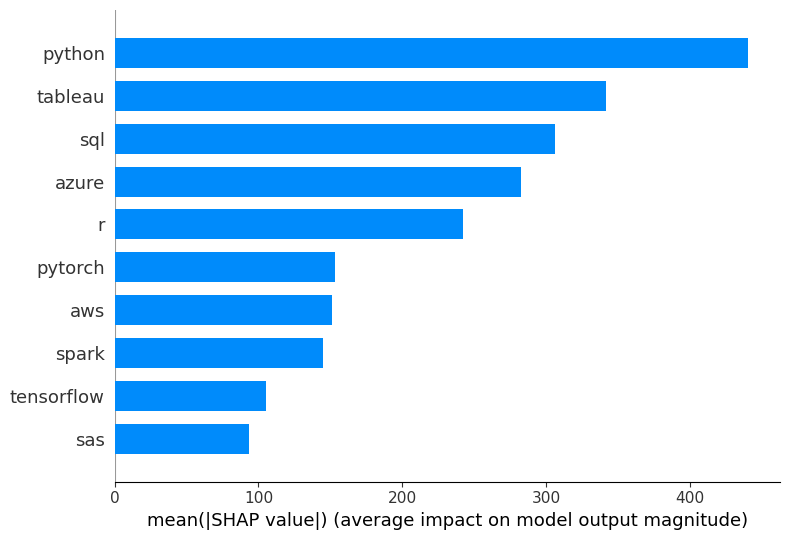

In [41]:
# Train
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot importance
shap.summary_plot(shap_values, X, plot_type="bar")

### Summary:

**Data Analyst**, **Data Scientist**, and **Data Engineer** as the three most in-demand data roles in the global job market, while the **Data Analyst** role is the most popular in Europe. Meanwhile, the higher demand for **Data Scientists** in the US suggests that this field will continue to expand globally, offering future opportunities.

The relatively lower skill count for **Data Analysts** suggests it is a more **accessible entry point** into the data field, making it a practical base role for further analysis.

Hiring activity for these top roles peaks in **January** and **mid-summer** (June–August), aligning with annual and mid-year planning cycles — valuable timing insight for job seekers.